# Vehicle Detection


### Import Functions

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
import pickle
import cv2
import os

from skimage.feature import hog
from scipy.ndimage.measurements import label

from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Functions that help Feature Extraction

In [2]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, tuple(bbox[0]), tuple(bbox[1]), color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [16]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
#         prediction = clf.predict_proba(test_features)
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction >= 0.7:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## Data processing 
### Read data and extract features

In [4]:
# Parameters

spatial_size = (16, 16)
hist_bins = 32

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12
pix_per_cell = 8 
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"   
spatial_feat = True 
hist_feat = True 
hog_feat = True
y_start_stop = [400, 650]


xy_window_size = (64, 64)
xy_overlap_size = (0.5, 0.5)

In [5]:
# Read in data for classifier
cars = glob.glob('./vehicles/*/*.png')
non_cars = glob.glob('./non-vehicles/*/*.png')

print('Loaded images')
  

# Extract features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print('Extracted features')
print('Car Samples', len(car_features))
print('Non-car samples', len(notcar_features))


Loaded images
Extracted features
Car Samples 8792
Non-car samples 8968


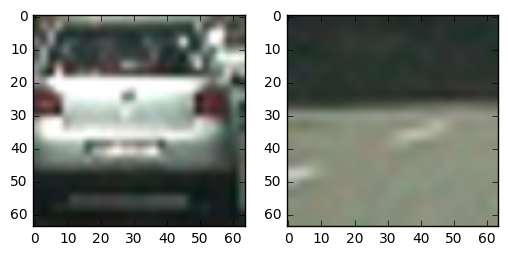

In [6]:
fig, axes = plt.subplots(1,2)
car_ind = np.random.randint(0, len(cars))
ex_img = mpimg.imread(cars[car_ind])


axes[0].imshow(ex_img)
axes[1].imshow(mpimg.imread(non_cars[car_ind]))

plt.show()
plt.savefig('./images/car_not_car.png')

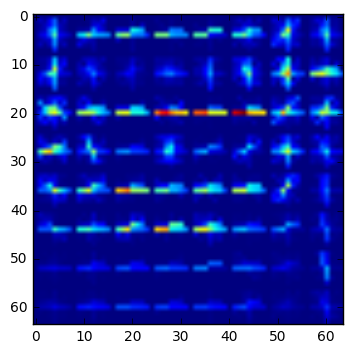

In [7]:

_, hog_img = get_hog_features(ex_img[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

plt.imshow(hog_img)
plt.show()
plt.savefig('./images/HOG_example.jpg')

## Build Classifier

We visualize the feature extractions that the classifier uses

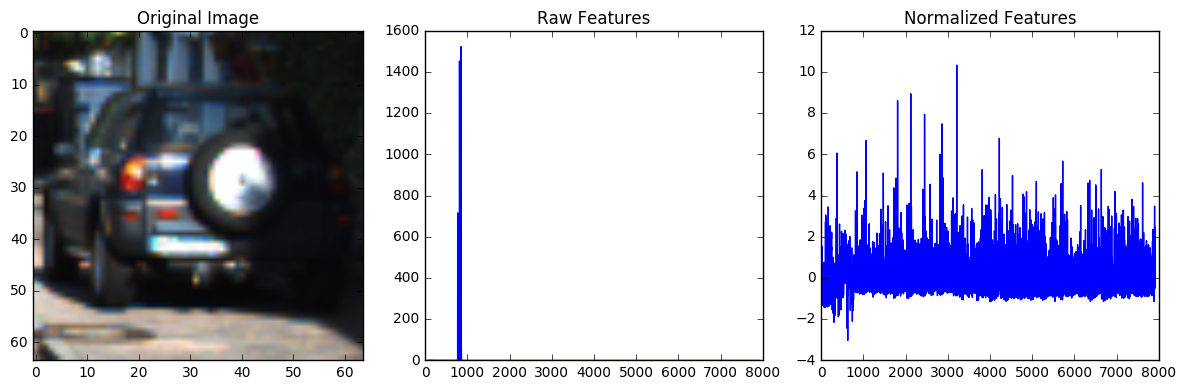

In [8]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
X_scaled = X_scaler.transform(X)
          
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(X_scaled[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
plt.show()

plt.savefig('./images/features.png')

In [11]:
X_scaled, y = shuffle(X_scaled, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

params = {
    'C': [0.5, 1, 2]
}

# svc = SVC(probability=True)
# LinearSVC
svc = LinearSVC()

# Perform GridSearch parameter optimization
clf = GridSearchCV(svc, params)
clf.fit(X_train, y_train)

svc = clf.best_estimator_

svc.fit(X_train, y_train)

predict = svc.predict(X_test)
acc = accuracy_score(y_test, predict)

print("Accuracy:", acc)
print("Best Params", clf.best_params_)

Accuracy: 0.992304804805
Best Params {'C': 0.5}


In [ ]:
print()

# pickle.dump(svc, 'svc.p')

In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img



### Sliding Window Search Space

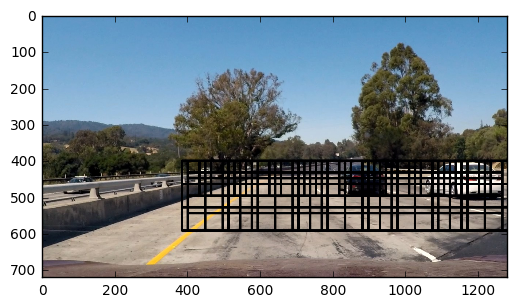

In [13]:
img = mpimg.imread('test_images/test1.jpg')
img = img.astype(np.float32)/255

draw_image = np.copy(img)

params = [
        [[384, 1280], [400, 600], (128, 128), [0.5, 0.5]],
        [[400, 1280], [400, 600], (96, 96), [0.5, 0.5]],
        [[400, 1280], [400, 500], (64, 64), [0.5, 0.5]]
]

windows = []
for p in params:
    windows.append(slide_window(ex_img, x_start_stop=p[0], y_start_stop=p[1], 
                    xy_window=p[2], xy_overlap=p[3]))

windows = np.vstack(windows)

draw_img = draw_boxes(draw_image, windows)
plt.imshow(draw_img)
plt.show()
plt.savefig('./images/sliding_windows.jpg')

In [17]:
draw_image = np.copy(img)

heat = np.zeros_like(img[:,:,0]).astype(np.float)
heatmap = np.clip(heat, 0, 255)

# Return all the windows the classifier has predicted contain car(s) ('positive windows').
hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 



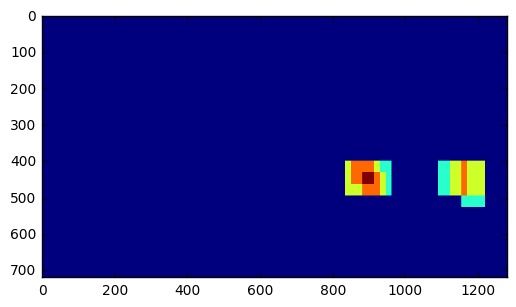

In [18]:
threshold = 1
# Add heat to each box in box list
heat = add_heat(heat, hot_windows)

# Apply threshold to help remove false positives
heat = apply_threshold(heat, threshold)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

plt.imshow(heatmap)
plt.show()
plt.savefig('./images/bboxes_and_heat.png')

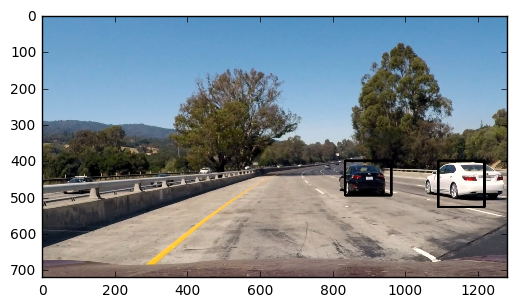

In [19]:
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

plt.imshow(draw_img)
plt.show()
plt.savefig('./images/output_bboxes.png')

In [41]:
class VehicleDetection:
    
    def __init__(self, threshold, params):
        self.heatmaps = []
        
        self.threshold = threshold
        
        windows = []
        for p in params:
            windows.append(slide_window(img, x_start_stop=p[0], y_start_stop=p[1], 
                            xy_window=p[2], xy_overlap=p[3]))

        self.windows = np.vstack(windows)

    def detect_vehicle(self, img):
        
        draw_img = img
        img = img.astype(np.float32)/255

        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        windows = self.windows
        
        # Return all the windows the classifier has predicted contain car(s) ('positive windows').
        hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat) 
        
        # Add heat to each box in box list
        heat = add_heat(heat, hot_windows)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, self.threshold)

        # Visualize the heatmap when displaying    
        self.heatmaps.append(np.clip(heat, 0, 255))
        
        if len(self.heatmaps) > 3:
            self.heatmaps.pop(0)
        
        heatmap = np.mean(np.array(self.heatmaps), axis=0)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(draw_img, labels)

        return draw_img
    

vd = VehicleDetection(0, params)

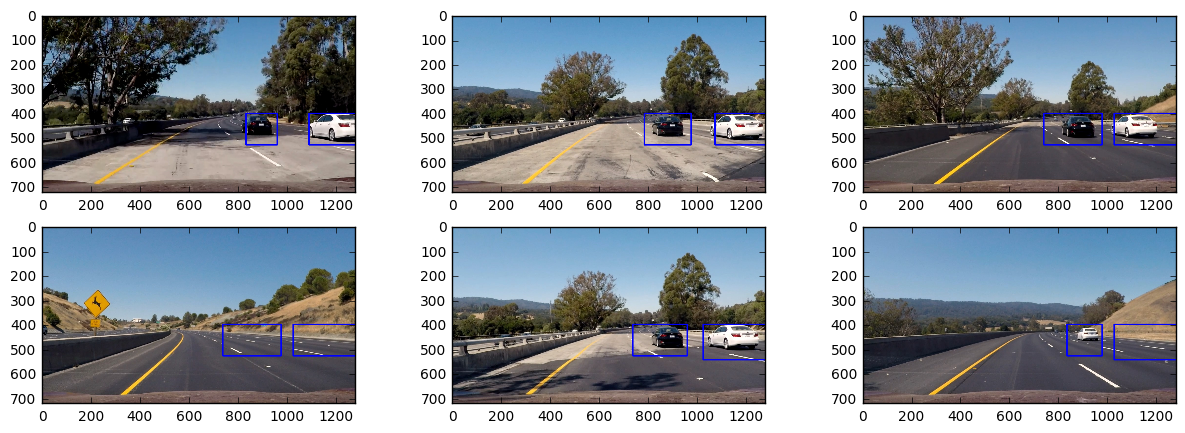

NameError: name 'ptl' is not defined

In [46]:
test_images = os.listdir('test_images')
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))

ind = [[0,0], [0,1], [0,2], [1,0], [1,1],[1,2]]
for i, img_name in enumerate(test_images):
    
    img = mpimg.imread('test_images/' + img_name)
    
    draw_image = np.copy(img)
    draw_image = vd.detect_vehicle(draw_image)
    axes[ind[i][0]][ind[i][1]].imshow(draw_image)
plt.show()
ptl.savefig('./images/test_images.png')

In [43]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


video = VideoFileClip("project_video.mp4")
project_clip = video.fl_image(vd.detect_vehicle) #NOTE: this function expects color images!!
video_output = "project_output.mp4"
project_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:00<18:33,  1.13it/s]



  0%|          | 2/1261 [00:01<18:30,  1.13it/s]



  0%|          | 3/1261 [00:02<18:27,  1.14it/s]



  0%|          | 4/1261 [00:03<18:25,  1.14it/s]



  0%|          | 5/1261 [00:04<18:22,  1.14it/s]



  0%|          | 6/1261 [00:05<18:21,  1.14it/s]



  1%|          | 7/1261 [00:06<18:20,  1.14it/s]



  1%|          | 8/1261 [00:07<18:18,  1.14it/s]



  1%|          | 9/1261 [00:07<18:17,  1.14it/s]



  1%|          | 10/1261 [00:08<18:16,  1.14it/s]



  1%|          | 11/1261 [00:09<18:16,  1.14it/s]



  1%|          | 12/1261 [00:10<18:15,  1.14it/s]



  1%|          | 13/1261 [00:11<18:15,  1.14it/s]



  1%|          | 14/1261 [00:12<18:16,  1.14it/s]



  1%|          | 15/1261 [00:13<18:14,  1.14it/s]



  1%|▏         | 16/1261 [00:14<18:12,  1.14it/s]



  1%|▏         | 17/1261 [00:14<18:11,  1.14it/s]



  1%|▏         | 18/1261 [00:15<18:10,  1.14it/s]



  2%|▏ 

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

